Analyze the chinook database, which contains information about a fictional digital music shop - kind of like a mini-iTunes store. 

import libraries

In [121]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

creating useful functions to: 
-  take query and return a dataframe
-  take query and execute
-  show table

In [11]:
def run_query(q): 
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
def show_tables():
    q_show_tables_views='''
        SELECT
            name,
            type
        From
            sqlite_master
        WHERE 
            type IN ("table","view");
        '''
    return(run_query(q_show_tables_views))

In [13]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. 

In [87]:
q_tracks_sold_by_genre_usa='''
    with tracks_sold_usa as
        (
        select
            track_id, 
            sum(quantity) total_sold
        from
            invoice_line
        left join
            invoice
        on 
            invoice_line.invoice_id = invoice.invoice_id
        left join
            customer
        on 
            customer.customer_id = invoice.customer_id
        where 
            customer.country = 'USA'
        group by 1
        )
    /*select sum(quantity) from invoice_line*/
    /*select sum(total_sold) from tracks_sold_usa*/
    /*select track_id, sum(quantity) from invoice_line group by 1 order by 2 desc limit 20*/
    /*select * from tracks_sold_usa order by 2 desc limit 20*/
    select
        genre.name,
        sum(total_sold) tracks_sold_per_genre, 
        cast(sum(total_sold) as float) / (select sum(total_sold) from tracks_sold_usa) tracks_sold_per_genre_pct
    from
        tracks_sold_usa
    left join 
        track
    on 
        tracks_sold_usa.track_id = track.track_id
    left join
        genre
    on
        genre.genre_id = track.genre_id
    group by 1
    order by 2 desc
    limit 20
    '''
run_query(q_tracks_sold_by_genre_usa)

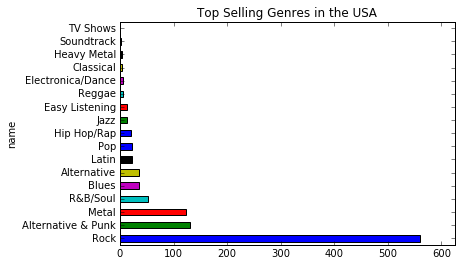

In [88]:
popular_usa_genre=run_query(q_tracks_sold_by_genre_usa)
popular_usa_genre.set_index("name", inplace=True, drop=True)
popular_usa_genre["tracks_sold_per_genre"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
)

Rock is by far the most popular genre in the USA. given the order of popularity, the recommendation is to add "Red Tone", "Slim Jim Bites", and "Meteor and the Girls". 

In [93]:
q_support_agent_perf='''
    with employee_sales as
        (
        select
            sum(total) total_sales, 
            support_rep_id
        from
            invoice
        left join
            customer
        on
            customer.customer_id = invoice.customer_id
        group by 2
        )
        
    select
        first_name || " " || last_name employee_name, 
        title, 
        hire_date, 
        total_sales
    from 
        employee
    inner join 
        employee_sales
    on
        employee.employee_id = employee_sales.support_rep_id
    order by 4 desc
    '''
run_query(q_support_agent_perf)

   employee_name                title            hire_date  total_sales
0   Jane Peacock  Sales Support Agent  2017-04-01 00:00:00      1731.51
1  Margaret Park  Sales Support Agent  2017-05-03 00:00:00      1584.00
2  Steve Johnson  Sales Support Agent  2017-10-17 00:00:00      1393.92


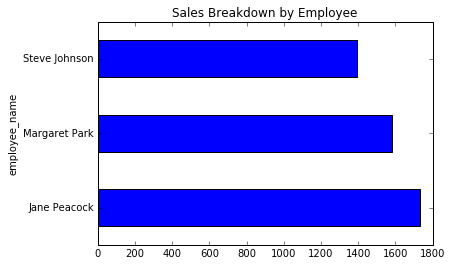

In [92]:
employee_sales=run_query(q_support_agent_perf)
employee_sales.set_index("employee_name", drop=True, inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
)

Right now, the most senior employee, Jane, is leading in sales. However, it seems that Steve is making sales at a great pace given his later employment. 

In [119]:
q_country_summary='''
    with country_count as
        (
        select
            country, 
            count(customer_id) as customer_count
        from 
            customer
        group by 1
        ), 
        customer_total_spending_value as
        (
        select
            customer.customer_id, 
            sum(total) total_spending,
            count(invoice_id) invoice_count
        from 
            customer
        left join
            invoice
        on 
            customer.customer_id = invoice.customer_id
        group by 1
        ), 
        customer_non_one_country as
        (
        select
            customer.*, 
            case
                when customer_count = 1 then "Other"
                else country_count.country
                end as fixed_country, 
            total_spending,
            invoice_count
        from
            customer
        inner join
            country_count
        on
            country_count.country = customer.country
        inner join 
            customer_total_spending_value
        on 
            customer.customer_id = customer_total_spending_value.customer_id
        )
    /*select * from customer_non_one_country where fixed_country = "Other"*/
    select 
        fixed_country country, 
        case
            when fixed_country = "Other" then 1
            else 0
            end sort, 
        count(customer_id) customer_count, 
        sum(total_spending) customer_total_sales,
        sum(total_spending) / count(customer_id) average_customer_sales,
        sum(total_spending) / sum(invoice_count) average_order_value
    from 
        customer_non_one_country
    group by 1
    order by 2, 4 desc 
    '''
run_query(q_country_summary)        

,country,sort,customer_count,customer_total_sales,average_customer_sales,average_order_value
0,USA,0,13,1040.49,80.037692,7.942672
1,Canada,0,8,535.59,66.948750,7.047237
2,Brazil,0,5,427.68,85.536000,7.011148
3,France,0,5,389.07,77.814000,7.781400
4,Germany,0,4,334.62,83.655000,8.161463
5,Czech Republic,0,2,273.24,136.620000,9.108000
6,United Kingdom,0,3,245.52,81.840000,8.768571
7,Portugal,0,2,185.13,92.565000,6.383793
8,India,0,2,183.15,91.575000,8.721429
9,Other,1,15,1094.94,72.996000,7.448571


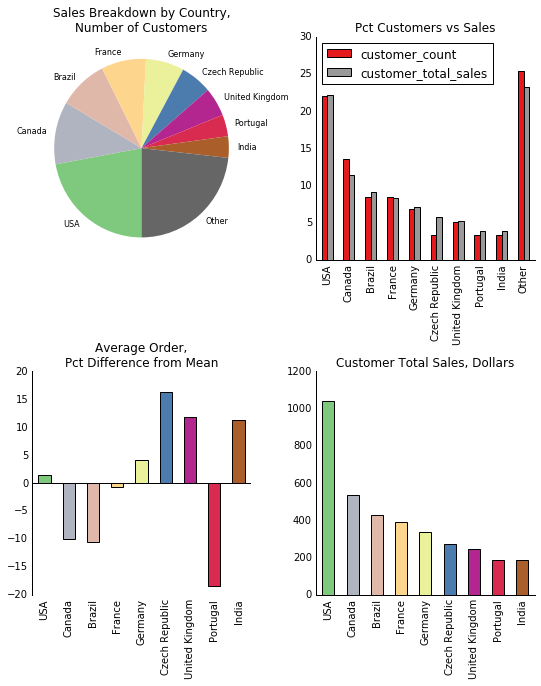

In [125]:
country_summary=run_query(q_country_summary)
country_summary.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_summary.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_breakdown=country_summary["customer_total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customer_count","customer_total_sales"]
custs_vs_dollars=country_summary[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country_summary["average_order_value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
customer_total_sales=country_summary["customer_total_sales"].copy()
customer_total_sales.index.name = ''
customer_total_sales.drop("Other",inplace=True)
customer_total_sales.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Total Sales, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

There are the most sales to USA customers. Czech Republic customers have the highest average sale per customer and per order. Czech Republic, United Kingdom, and India customers have big potentials. 

In [140]:
q_invoice_or_album='''
    WITH invoice_first_track AS
        (
            SELECT
            il.invoice_id invoice_id,
            MIN(il.track_id) first_track_id
        FROM invoice_line il
        GROUP BY 1
        )
    SELECT
        album_purchase,
        COUNT(invoice_id) number_of_invoices,
        CAST(count(invoice_id) AS FLOAT) / (SELECT 
                                                COUNT(*) FROM invoice
                                                ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                (
                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                    SELECT t2.album_id FROM track t2
                    WHERE t2.track_id = ifs.first_track_id
                    ) 
                EXCEPT 
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ifs.invoice_id
                ) IS NULL
             AND
                (
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ifs.invoice_id
                EXCEPT 
                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                    SELECT t2.album_id FROM track t2
                    WHERE t2.track_id = ifs.first_track_id
                    ) 
                ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
     order by invoice_id
    '''
run_query(q_invoice_or_album)

,invoice_id,first_track_id,album_purchase
0,1,1158,yes
1,2,201,no
2,3,2516,no
3,4,748,no
4,5,1986,yes
5,6,30,no
6,7,42,no
7,8,81,no
8,9,196,no
9,10,2663,no
